<a href="https://colab.research.google.com/github/paramate-p/selected-topic-cmu/blob/main/lecture05/workshop5/workshop5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download lucasturtle/national-anthems-of-the-world

Dataset URL: https://www.kaggle.com/datasets/lucasturtle/national-anthems-of-the-world
License(s): copyright-authors
  0% 0.00/54.4k [00:00<?, ?B/s]
100% 54.4k/54.4k [00:00<00:00, 50.5MB/s]


In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [ ]:
import pandas as pd
import zipfile

# Unzip the dataset
zip_path = './national-anthems-of-the-world.zip'
extract_path = '.'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
df = pd.read_csv('anthems.csv')
df.head()

,Country,Alpha-2,Alpha-3,Continent,Anthem
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea..."


In [ ]:
df.describe()

,Country,Alpha-2,Alpha-3,Continent,Anthem
count,190,189,190,190,190
unique,190,188,190,6,188
top,Albania,CH,ALB,Africa,"Arise, ye who refuse to be slaves; With our ve..."
freq,1,2,1,56,2


There are 190 different countries and 6 continents

## Step 1: Check for Missing value and outlier and plots

In [ ]:
df.isnull().sum()

,0
Country,0
Alpha-2,1
Alpha-3,0
Continent,0
Anthem,0


## Step 2: Perform EDA

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

custom_stopwords = set([
    "the", "and", "of", "to", "a", "in", "that", "we", "our", "for", "is", "on", "by", "with",
    "at", "from", "as", "it", "an", "this", "which", "be", "are", "am", "was", "were", "been",
    "being", "has", "have", "had", "do", "does", "did", "can", "could", "shall", "should",
    "will", "would", "may", "might", "must", "let", "us", "your", "you", "i", "he", "she",
    "they", "them", "its", "thy", "o", "u"
])


# Function to preprocess text
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()  # Convert to lowercase
        text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and punctuation
        words = word_tokenize(text)  # Tokenization
        words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Remove stopwords & lemmatize
        words = [word for word in words if word not in custom_stopwords]
        return ' '.join(words)
    return text

# Function to tokenize text and count word frequency
def get_word_frequencies(text_series):
    all_words = ' '.join(text_series.dropna()).split()
    return Counter(all_words)

In [ ]:
# Apply preprocessing to 'Anthem' column
df['Anthem_Cleaned'] = df['Anthem'].apply(preprocess_text)
df.head()

,Country,Alpha-2,Alpha-3,Continent,Anthem,Anthem_Cleaned,Anthem_Length
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish...",around flag stand united one wish one goal sac...,69
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo...",fatherland free independent century lived summ...,37
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ...",land mountain land river land field land cathe...,68
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan...",azerbaijan azerbaijan glorious fatherland valo...,73
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea...",belarusian peaceful people wholeheartedly devo...,72


In [ ]:
# df['Anthem_Cleaned'] = df['Anthem_Cleaned'].fillna("").astype(str)

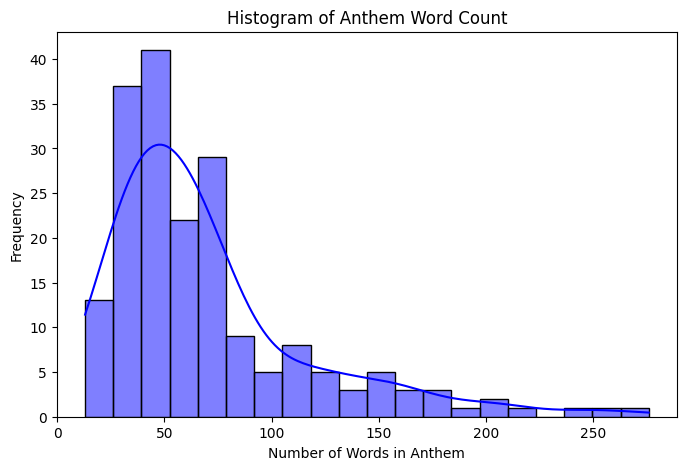

In [ ]:
df['Anthem_Length'] = df['Anthem_Cleaned'].str.split().str.len()
plt.figure(figsize=(8, 5))
sns.histplot(df['Anthem_Length'], bins=20, kde=True, color='blue')
plt.xlabel("Number of Words in Anthem")
plt.ylabel("Frequency")
plt.title("Histogram of Anthem Word Count")
plt.show()

The histogram shows that most anthems have between 30 to 100 words, with a peak around 50 words.
The distribution is right-skewed, meaning a few anthems are significantly longer (200-400 words), but most are relatively concise.
This suggests that national anthems tend to be short, likely for memorization and ease of singing.


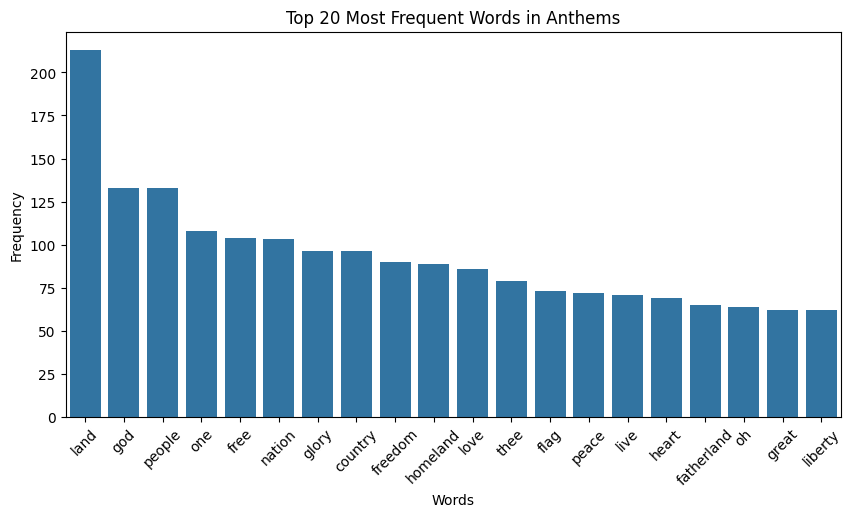

In [ ]:
# 2. Bar Chart: Overall Word Frequency
word_freq = get_word_frequencies(df['Anthem_Cleaned'])
top_words = word_freq.most_common(20)

plt.figure(figsize=(10, 5))
sns.barplot(x=[word[0] for word in top_words], y=[word[1] for word in top_words])
plt.xticks(rotation=45)
plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Top 20 Most Frequent Words in Anthems")
plt.show()

* Dominant words: "land", "people", "glory", "homeland",
"freedom", "nation", "flag".

* These words now strongly emphasize territory (land), identity (people, homeland), and patriotism (flag, glory, freedom).


* Words like "god", "love", and "peace" remain frequent, showing religious and unity themes in national anthems.

    Continent     Word  Frequency
93     Africa      one       51.0
178    Africa     land       48.0
89     Africa   people       46.0
180    Africa      god       40.0
49     Africa   nation       32.0
103    Africa    peace       31.0
92     Africa  freedom       30.0
96     Africa   africa       30.0
380    Africa     thee       28.0
127    Africa    unity       26.0
270    Africa     love       26.0
91     Africa  country       25.0
259    Africa    heart       25.0
614    Africa    bless       25.0
16     Africa     live       24.0
135    Africa     sing       23.0
242    Africa  liberty       23.0
261    Africa     free       21.0
8      Africa     flag       20.0
65     Africa       oh       20.0


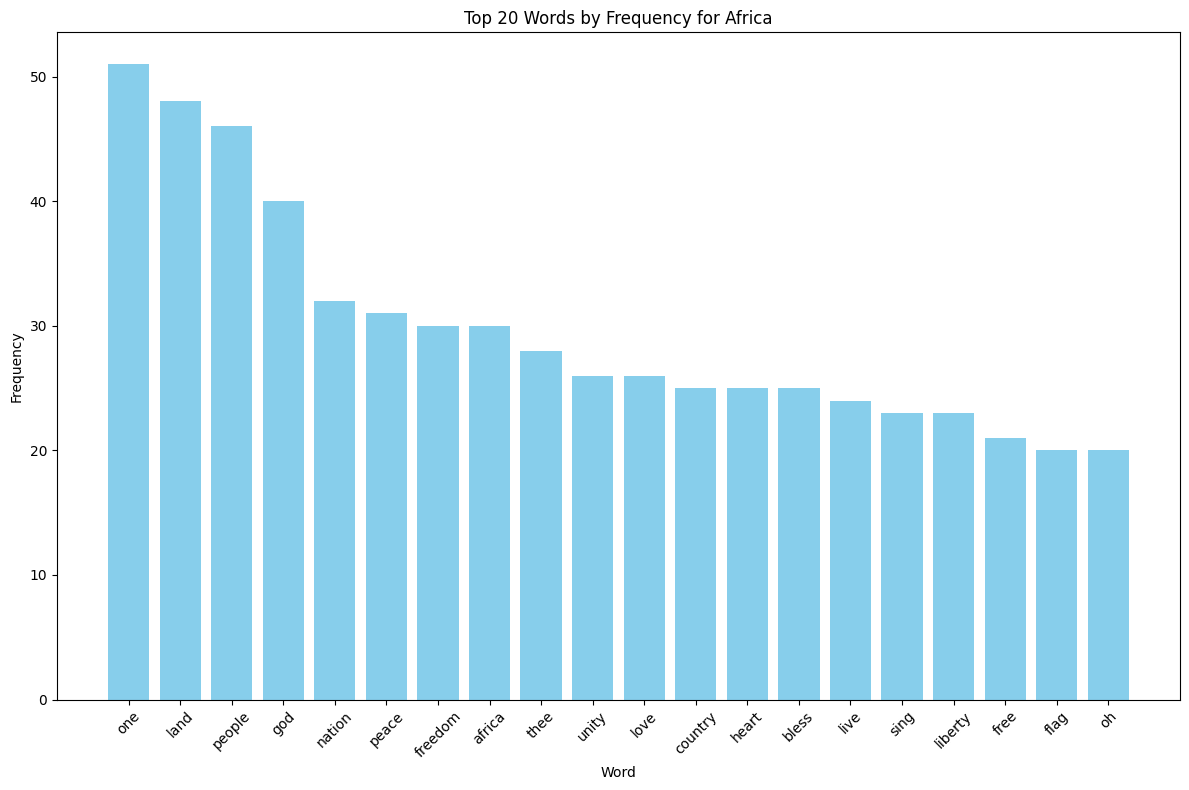

     Continent       Word  Frequency
3529      Asia       land       50.0
3442      Asia    country       47.0
3440      Asia     people       37.0
3400      Asia     nation       26.0
3790      Asia      great       25.0
3844      Asia   homeland       23.0
3393      Asia      glory       22.0
3359      Asia       flag       21.0
3444      Asia        one       21.0
3459      Asia       long       21.0
3423      Asia     salute       18.0
3367      Asia       live       17.0
3458      Asia      world       17.0
3610      Asia      heart       17.0
3394      Asia     spirit       16.0
3612      Asia       free       16.0
4116      Asia       time       16.0
3356      Asia      blood       15.0
3416      Asia         oh       14.0
4728      Asia  indonesia       14.0


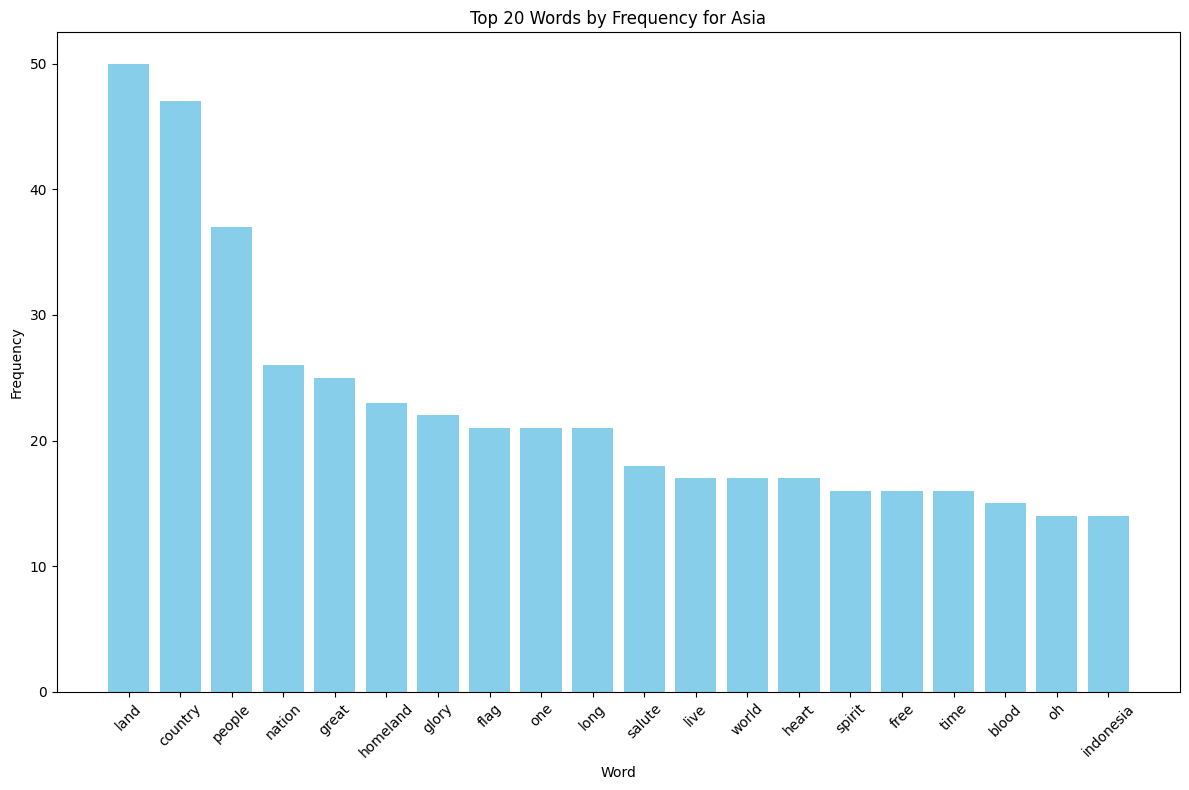

     Continent        Word  Frequency
6880    Europe        land       50.0
6882    Europe         god       37.0
6757    Europe  fatherland       32.0
6718    Europe        live       19.0
6744    Europe       glory       18.0
6810    Europe        long       18.0
6958    Europe         arm       18.0
6751    Europe      nation       17.0
6710    Europe        flag       16.0
6791    Europe      people       16.0
6961    Europe       heart       16.0
6972    Europe        love       16.0
6794    Europe     freedom       15.0
6865    Europe        dear       15.0
7160    Europe        song       15.0
7403    Europe        home       15.0
6809    Europe       world       14.0
6775    Europe         son       13.0
6839    Europe       light       13.0
6906    Europe    thousand       13.0


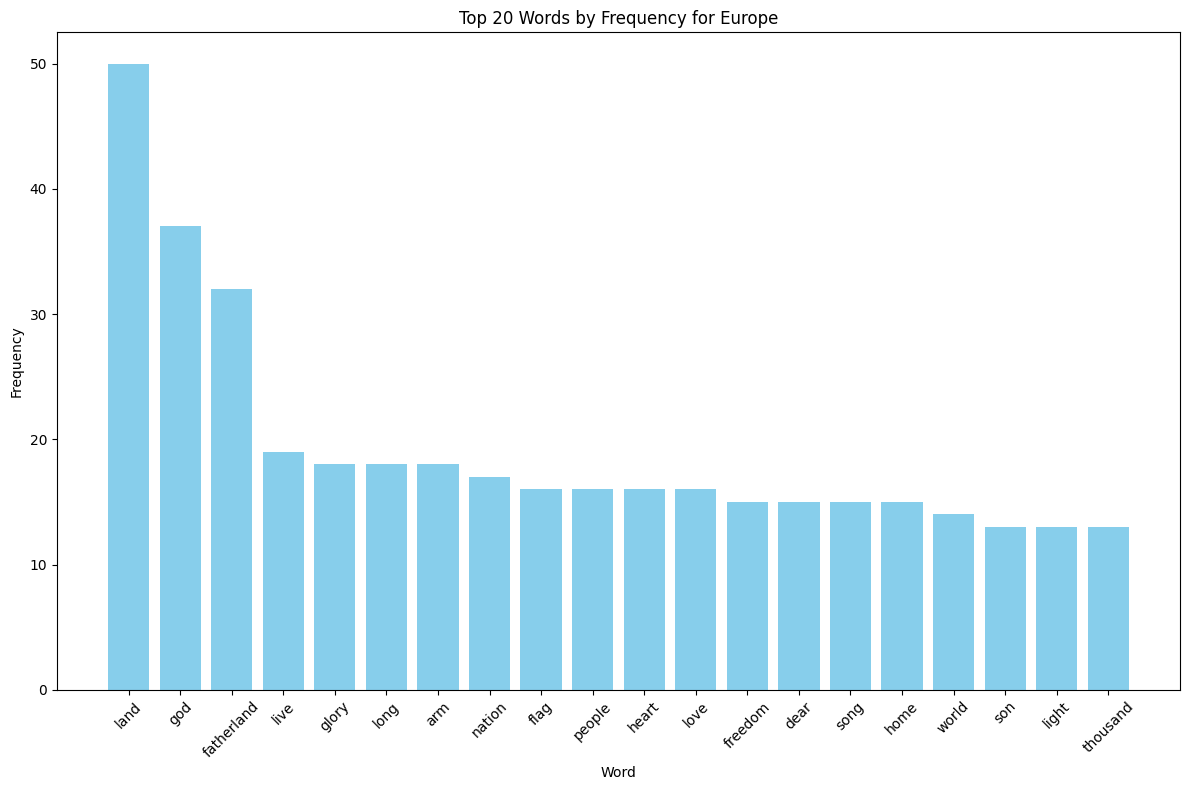

           Continent     Word  Frequency
10231  North_America     land       32.0
10314  North_America     free       23.0
12656  North_America   canada       20.0
10433  North_America     thee       19.0
10323  North_America     love       18.0
10244  North_America    stand       15.0
10095  North_America    glory       14.0
10453  North_America      sea       14.0
10562  North_America      war       13.0
10669  North_America    brave       13.0
10941  North_America    guard       13.0
10102  North_America   nation       12.0
10061  North_America     flag       11.0
10126  North_America      son       11.0
10156  North_America    peace       11.0
10233  North_America      god       11.0
10295  North_America  liberty       11.0
10700  North_America   banner       11.0
10112  North_America     call       10.0
10118  North_America       oh       10.0


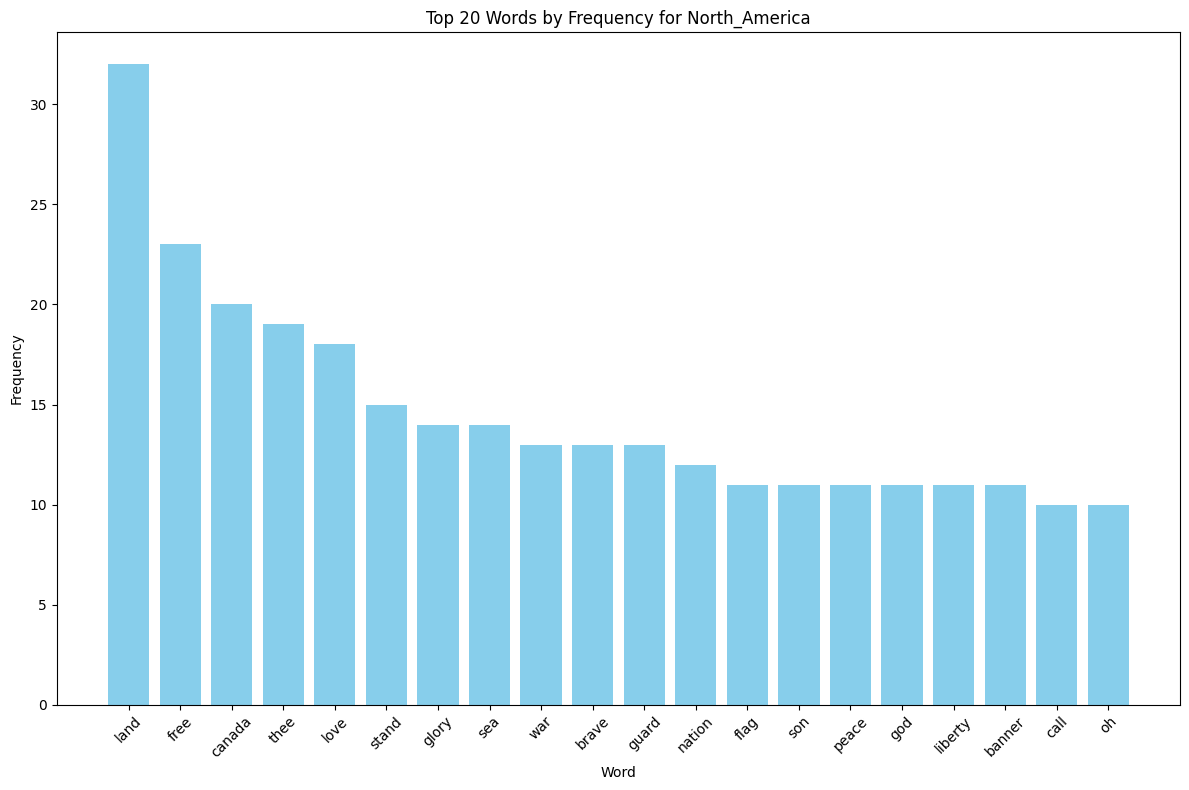

      Continent     Word  Frequency
13584   Oceania      god       24.0
13582   Oceania     land       16.0
13483   Oceania      new       11.0
13928   Oceania   defend       11.0
13665   Oceania     free       10.0
16397   Oceania     fiji       10.0
13493   Oceania   people        9.0
13674   Oceania     love        9.0
13441   Oceania     make        6.0
13453   Oceania   nation        6.0
13471   Oceania     hand        6.0
13761   Oceania     ever        6.0
13801   Oceania   island        6.0
13927   Oceania   guinea        6.0
14018   Oceania    bless        6.0
16383   Oceania    papua        6.0
13784   Oceania     thee        5.0
16389   Oceania  zealand        5.0
16404   Oceania    samoa        5.0
13469   Oceania       oh        4.0


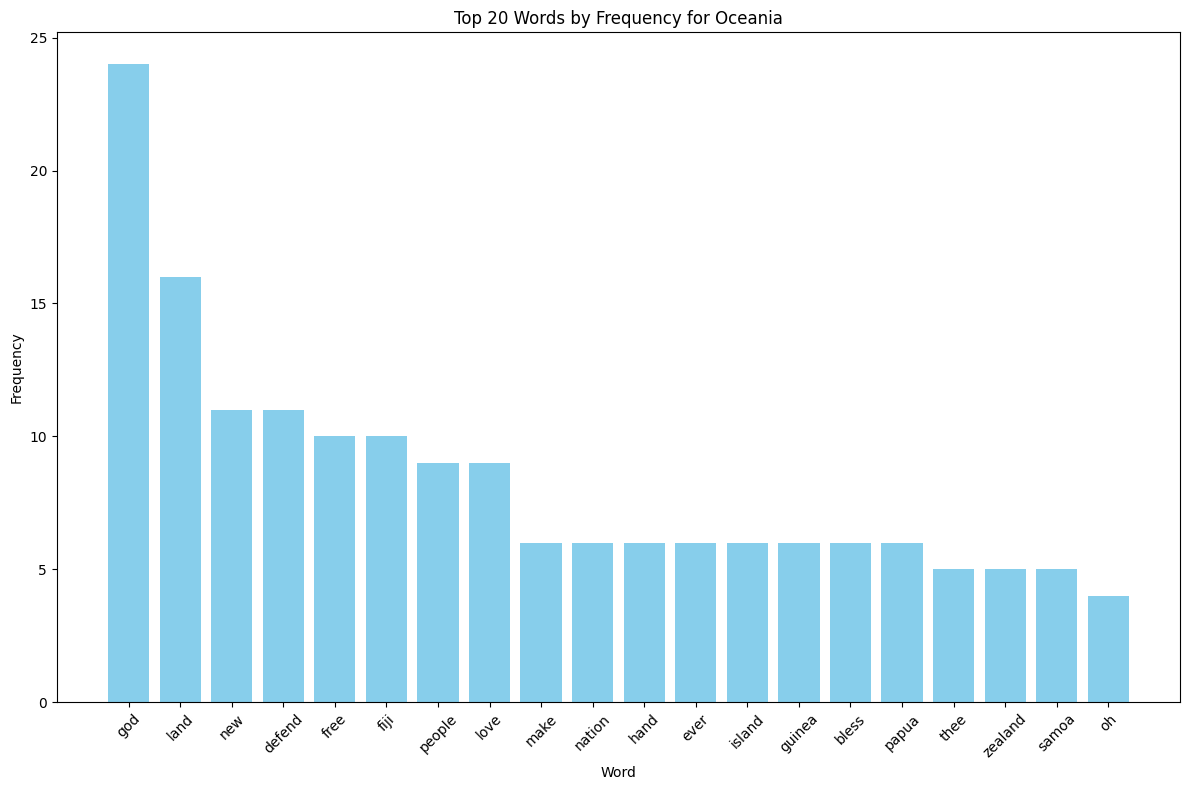

           Continent      Word  Frequency
16847  South_America   freedom       26.0
17248  South_America  homeland       26.0
17016  South_America      free       25.0
16797  South_America     glory       23.0
16772  South_America       die       20.0
16933  South_America      land       17.0
17056  South_America       vow       17.0
18104  South_America     slave       17.0
16997  South_America   liberty       16.0
20094  South_America   fulfill       16.0
16844  South_America    people       15.0
17042  South_America   eternal       13.0
16848  South_America       one       12.0
16952  South_America      name       12.0
17664  South_America    living       12.0
16809  South_America       cry       11.0
16892  South_America     light       11.0
17483  South_America    tyrant       11.0
17878  South_America     break       11.0
18015  South_America       see       11.0


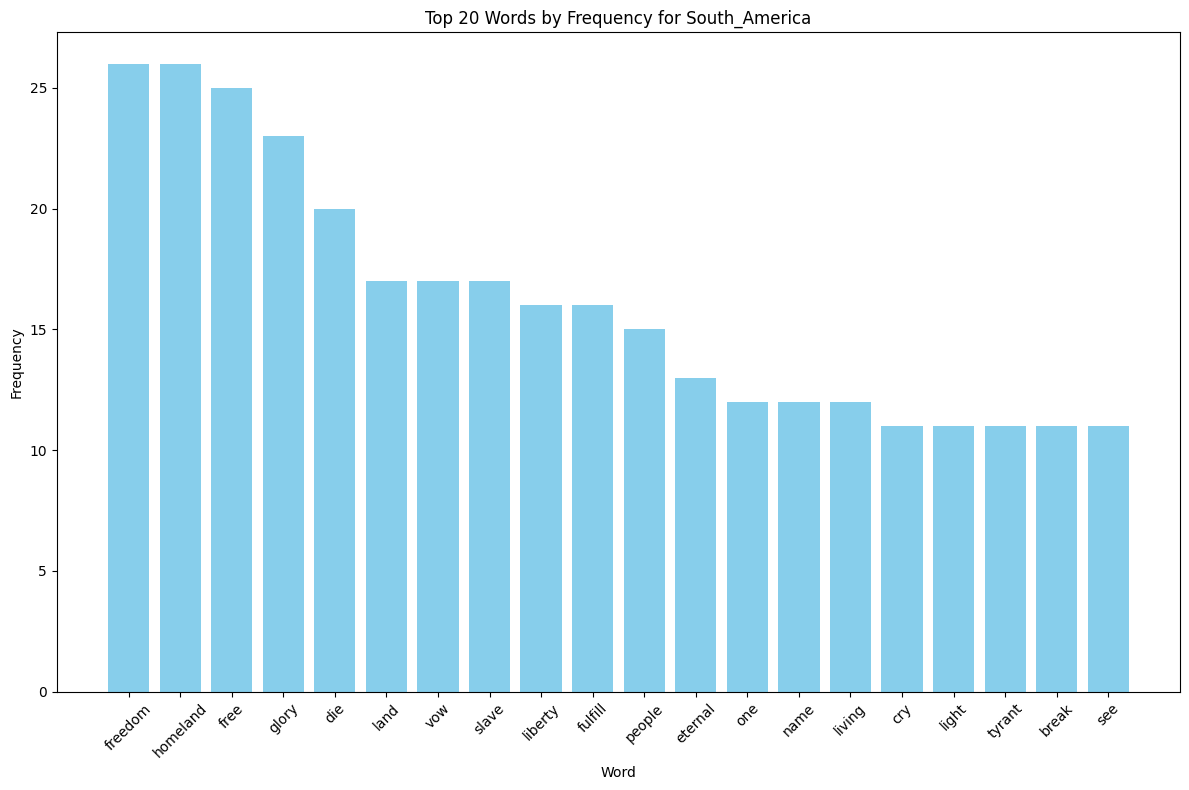

In [ ]:
# 3. Bar Chart: Word Frequency by Continent
continent_word_freq = df.groupby('Continent')['Anthem_Cleaned'].apply(get_word_frequencies).to_dict()

_df = pd.DataFrame(
    [(continent, word, freq) for ((continent, word), freq) in continent_word_freq.items()],
    columns=['Continent', 'Word', 'Frequency']
)
# Iterate over each continent
for continent in _df['Continent'].unique():
    # Filter data for the current continent
    subset = _df[_df['Continent'] == continent]

    # Get the top 20 words by frequency for the current continent
    subset_top20 = subset.nlargest(20, 'Frequency')
    print(subset_top20)

    # Plotting the bar chart for the current continent
    plt.figure(figsize=(12, 8))
    plt.bar(subset_top20['Word'], subset_top20['Frequency'], color='skyblue')
    plt.title(f'Top 20 Words by Frequency for {continent}')
    plt.xlabel('Word')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45)
    plt.tight_layout()  # Adjust layout to prevent clipping of tick labels
    plt.show()

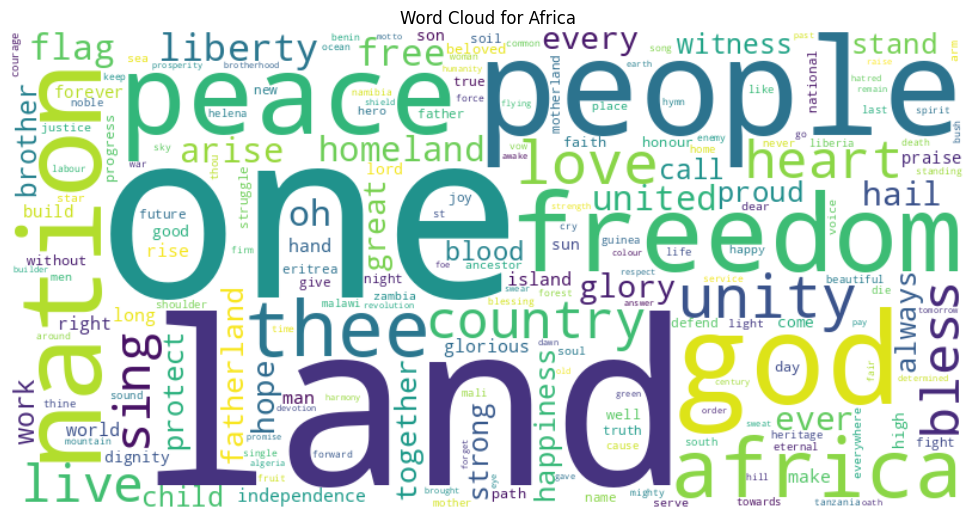

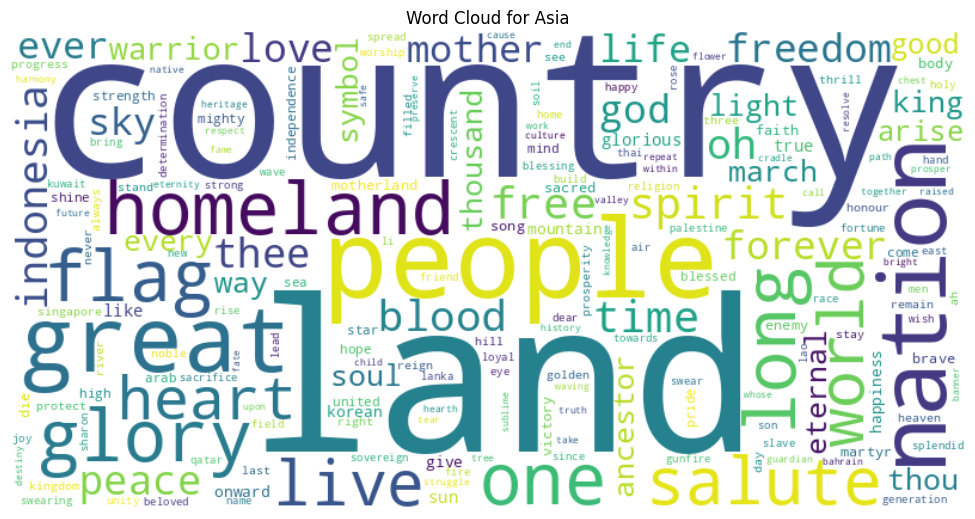

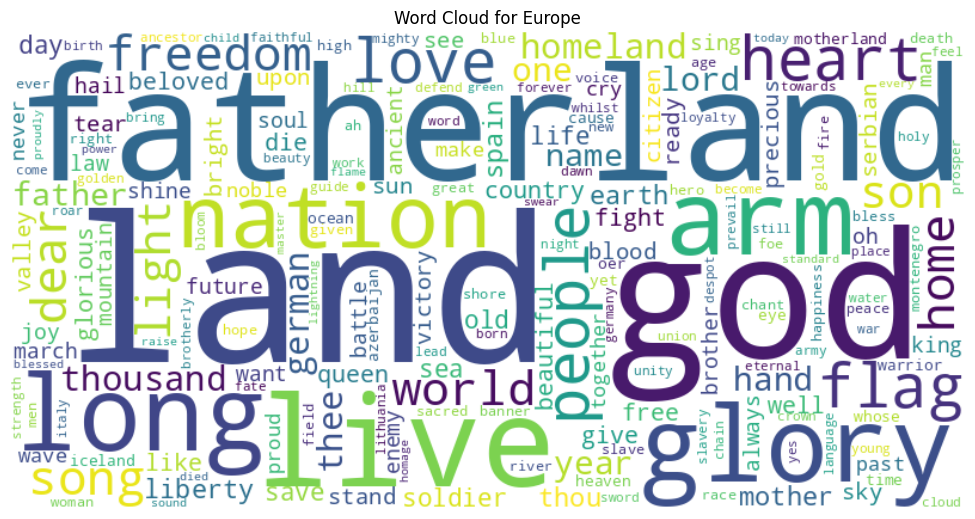

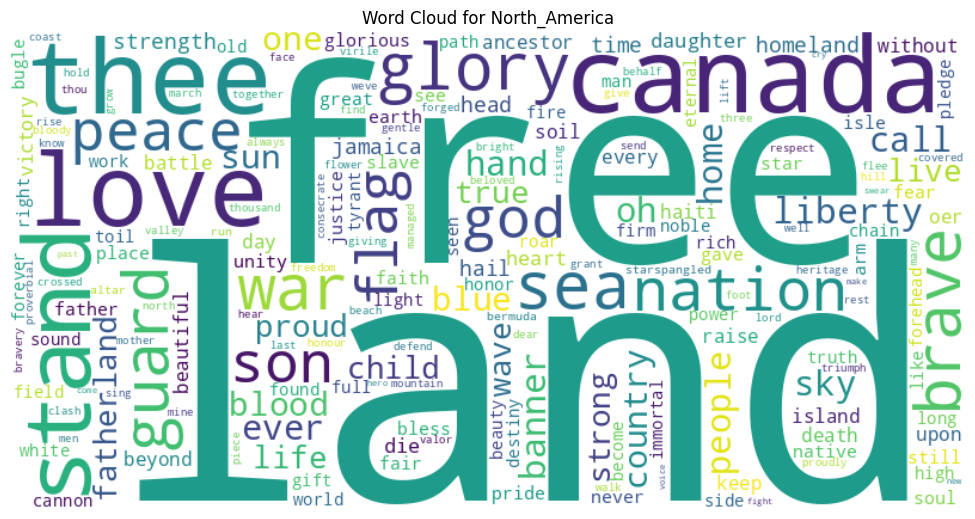

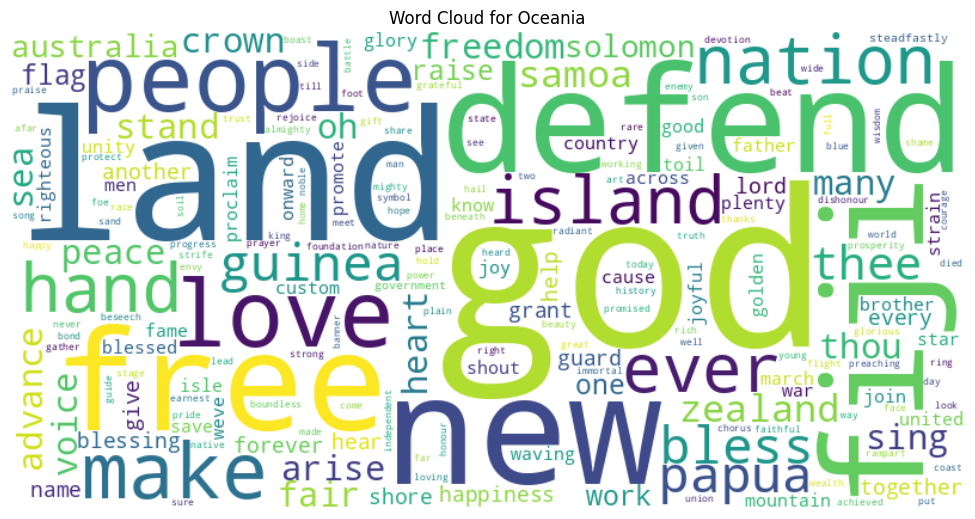

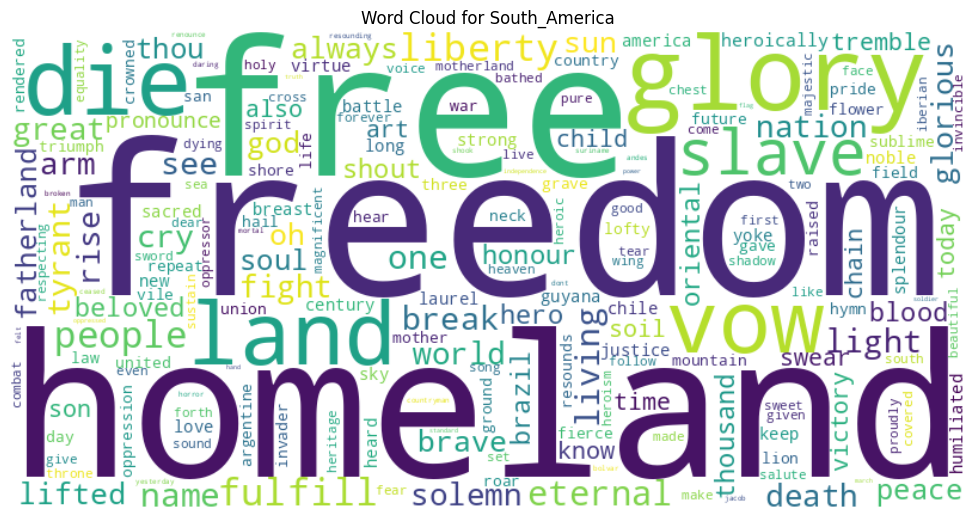

In [ ]:
# Generate and plot a word cloud for each continent
for continent in _df['Continent'].unique():
    # Filter data for the current continent
    subset = _df[_df['Continent'] == continent]

    # Create a dictionary of word frequencies for the current continent
    word_freq = dict(zip(subset['Word'], subset['Frequency']))

    # Filter out any entries with NaN frequencies
    word_freq = {word: freq for word, freq in word_freq.items() if pd.notna(freq)}

    # Check if we have valid words to display
    if not word_freq:
        print(f"No valid word frequencies for {continent}")
        continue

    # Generate the word cloud
    wc = WordCloud(width=800, height=400, background_color='white')
    wordcloud = wc.generate_from_frequencies(word_freq)

    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {continent}')
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()

### Summary of National Anthem Themes by Continent

* Africa
  * Themes: Unity, Freedom, Religion, and Peace
  * Frequent Words: "one", "land", "people", "god", "nation", "freedom", "peace", "bless", "liberty".
  * Insight: African anthems emphasize national unity, independence from colonial rule, religious devotion, and aspirations for peace.

* Asia
  * Themes: Greatness, National Identity, and Strength
  * Frequent Words: "land", "country", "people", "nation", "great", "homeland", "glory", "long", "salute".
  * Insight: Asian anthems focus on national pride, strength, resilience, and honoring the country’s greatness and legacy.

* Europe
  * Themes: Heritage, Patriotism, and Glory
  * Frequent Words: "land", "god", "fatherland", "live", "glory", "nation", "flag", "freedom", "song".
  * Insight: European anthems emphasize deep historical roots, patriotic pride, and the glorification of their homelands.

* North America
  * Themes: Freedom, Bravery, and Defense
  * Frequent Words: "land", "free", "glory", "brave", "guard", "peace", "war", "liberty", "banner".
  * Insight: North American anthems highlight freedom, bravery in battle, and the importance of national defense.

* Oceania
  * Themes: Faith, Unity, and Protection
  * Frequent Words: "god", "land", "free", "defend", "people", "love", "nation", "bless", "island".
  * Insight: Oceania’s anthems reflect faith in God, unity among island nations, and a strong sense of protection for their homeland.


* South America
  * Themes: Freedom, Struggle, and Sacrifice
  * Frequent Words: "freedom", "homeland", "glory", "die", "liberty", "slave", "vow", "eternal", "tyrant".
  * Insight: South American anthems are strongly influenced by past struggles, focusing on liberty, resistance against oppression, and the will to fight for freedom.

## Step 3: Scaling using standard scalar

In [ ]:
# Apply TF-IDF transformation
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(df['Anthem_Cleaned'])

# Convert TF-IDF matrix to a dense array
tfidf_array = tfidf_matrix.toarray()

# Apply StandardScaler to the TF-IDF scores
scaler = StandardScaler()
tfidf_scaled = scaler.fit_transform(tfidf_array)
tfidf_scaled_df = pd.DataFrame(tfidf_scaled, columns=vectorizer.get_feature_names_out())
tfidf_scaled_df.head()

,abandon,abanyarwanda,abide,ablaze,able,abound,abounds,abrandished,absolute,abstains,...,youthful,youve,zambezi,zambia,zeal,zealand,zealous,zenith,zimbabwe,zion
0,-0.1027,-0.072739,-0.072739,-0.072739,-0.122231,-0.072739,-0.072739,13.747727,-0.072739,13.747727,...,-0.072739,-0.10277,-0.072739,-0.072739,-0.126624,-0.072739,-0.072739,-0.101408,-0.072739,-0.072739
1,-0.1027,-0.072739,-0.072739,-0.072739,-0.122231,-0.072739,-0.072739,-0.072739,-0.072739,-0.072739,...,-0.072739,-0.10277,-0.072739,-0.072739,-0.126624,-0.072739,-0.072739,-0.101408,-0.072739,-0.072739
2,-0.1027,-0.072739,-0.072739,-0.072739,-0.122231,-0.072739,-0.072739,-0.072739,-0.072739,-0.072739,...,-0.072739,-0.10277,-0.072739,-0.072739,-0.126624,-0.072739,-0.072739,-0.101408,-0.072739,-0.072739
3,-0.1027,-0.072739,-0.072739,-0.072739,-0.122231,-0.072739,-0.072739,-0.072739,-0.072739,-0.072739,...,-0.072739,-0.10277,-0.072739,-0.072739,-0.126624,-0.072739,-0.072739,-0.101408,-0.072739,-0.072739
4,-0.1027,-0.072739,-0.072739,-0.072739,-0.122231,-0.072739,-0.072739,-0.072739,-0.072739,-0.072739,...,-0.072739,-0.10277,-0.072739,-0.072739,-0.126624,-0.072739,-0.072739,-0.101408,-0.072739,-0.072739


## Step 4: Modelling with k-mean and Hierarchical Clustering

In [ ]:
# K-Means Clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
df['KMeans_Cluster'] = kmeans.fit_predict(tfidf_scaled_df)
df.head()

,Country,Alpha-2,Alpha-3,Continent,Anthem,Anthem_Cleaned,Anthem_Length,KMeans_Cluster
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish...",around flag stand united one wish one goal sac...,69,1
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo...",fatherland free independent century lived summ...,36,1
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ...",land mountain land river land field land cathe...,66,1
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan...",azerbaijan azerbaijan glorious fatherland valo...,72,1
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea...",belarusian peaceful people wholeheartedly devo...,72,1


In [ ]:
# Hierarchical Clustering
hierarchical = AgglomerativeClustering(n_clusters=5, linkage='ward')
df['Hierarchical_Cluster'] = hierarchical.fit_predict(tfidf_scaled_df)
df.head()

,Country,Alpha-2,Alpha-3,Continent,Anthem,Anthem_Cleaned,Anthem_Length,KMeans_Cluster,Hierarchical_Cluster
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish...",around flag stand united one wish one goal sac...,69,1,0
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo...",fatherland free independent century lived summ...,36,1,0
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ...",land mountain land river land field land cathe...,66,1,0
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan...",azerbaijan azerbaijan glorious fatherland valo...,72,1,0
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea...",belarusian peaceful people wholeheartedly devo...,72,1,0


## Step 5: Find and optimal number of cluster

In [ ]:
from sklearn.metrics import silhouette_score
import numpy as np

# Determine the optimal number of clusters using the Elbow Method and Silhouette Score
inertia = []
silhouette_scores = []
cluster_range = range(2, 11)  # Testing clusters from 2 to 10

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(tfidf_scaled_df)

    inertia.append(kmeans.inertia_)  # Sum of squared distances to closest cluster center
    silhouette_scores.append(silhouette_score(tfidf_scaled_df, cluster_labels))  # Silhouette score

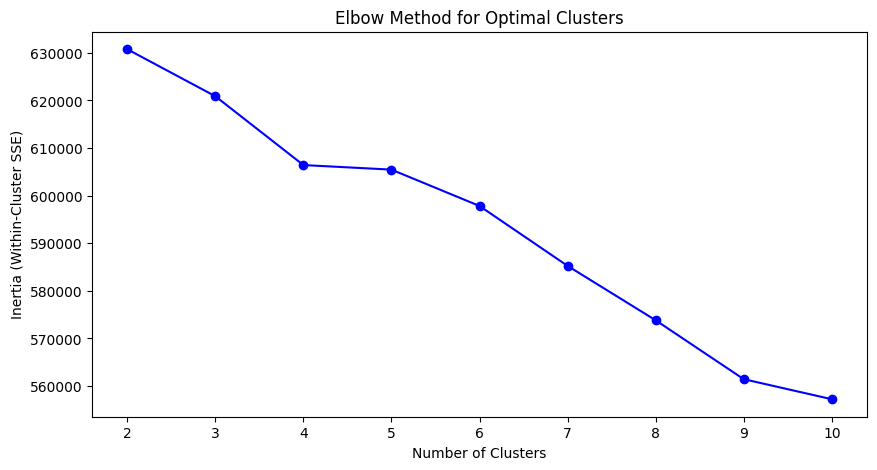

In [ ]:
# Plot the Elbow Method
plt.figure(figsize=(10, 5))
plt.plot(cluster_range, inertia, marker='o', linestyle='-', color='blue')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia (Within-Cluster SSE)')
plt.title('Elbow Method for Optimal Clusters')
plt.show()

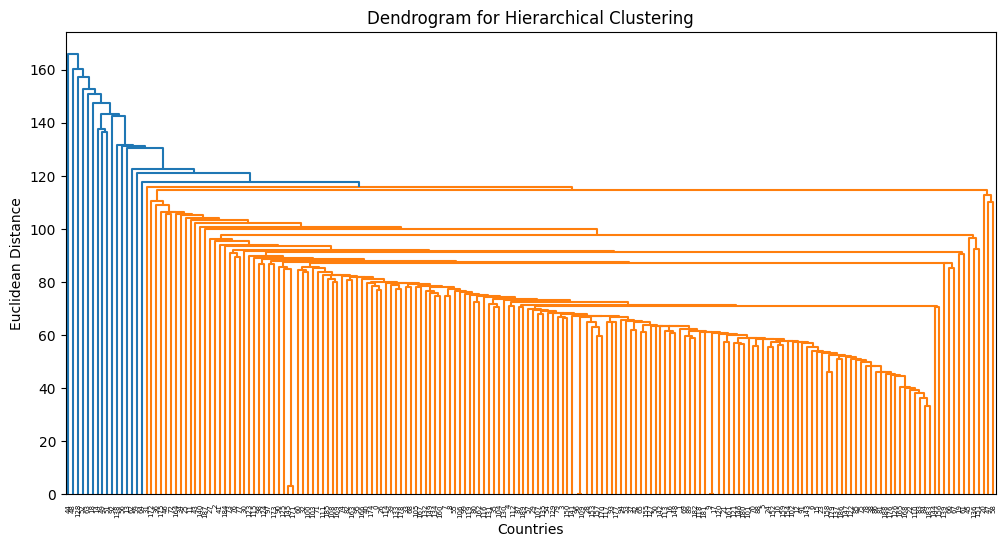

In [ ]:
plt.figure(figsize=(12, 6))
sch.dendrogram(sch.linkage(tfidf_scaled_df, method='ward'))
plt.title("Dendrogram for Hierarchical Clustering")
plt.xlabel("Countries")
plt.ylabel("Euclidean Distance")
plt.show()

* Elbow method

  After 4 clusters, the decrease becomes more gradual
  The elbow appears to be around 4 or 5 clusters.

  Thus, the optimal number of clusters is likely 4 or 5

* Dendrogram

  - In this case, a cut around 100-120 on the Euclidean distance scale could yield 2-3 main clusters.
  - The dendrogram suggests a hierarchical grouping of countries.

